## Non-linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import pickle
input = open('data_reg.pkl', 'rb')
obj = pickle.load(input)
input.close()
X_train = obj["X_train"]
X_test = obj["X_test"]
y_train = obj["y_train"]
y_test = obj["y_test"]

Запишем в переменную f наиболее значимые факторы.

In [3]:
f = ['Numb_students_per_Staff','Percentage_Female','Percentage_Male','Teaching','GDP']

Пропишем функцию для некоторых метрик для удобства.

In [4]:
def metrics(X_train, X_test, y_train, y_test, y_pred, model):
    RMSE = [mean_squared_error(y_train, model.predict(X_train),squared=False), mean_squared_error(y_test, y_pred, squared=False)]
    R2 = [model.score(X_train, y_train), model.score(X_test, y_test)]
    results = {'RMSE': RMSE, 'R2':R2}
    return pd.DataFrame(results, index=['Train', 'Test'])

## Regression Tree

По графику ниже приблизительно вычислим необходимую глубину дерева.

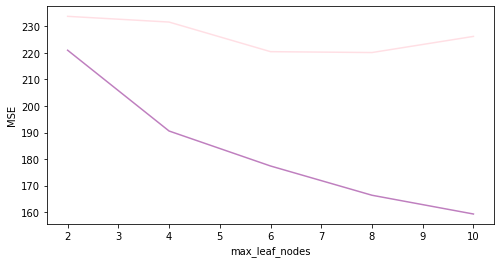

In [5]:
 def max_leaf_nodes(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        dt = DecisionTreeRegressor(max_leaf_nodes = i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, dt.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, dt.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='purple', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='pink', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_leaf_nodes")
    
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
max_leaf_nodes(X_train[f], X_test[f], y_train, y_test, [2, 4, 6, 8, 10])

Экспериментальным путём мы определили, что оптимальная глубина дерева 2, так как при этом значении наименьшее расхождение среднеквадратических ошибок.

In [16]:
dt = DecisionTreeRegressor(max_leaf_nodes = 2).fit(X_train[f], y_train)

dt_y_pred = dt.predict(X_test[f])

metrics(X_train[f], X_test[f], y_train, y_test, dt_y_pred, dt).round(2)

,RMSE,R2
Train,14.87,0.15
Test,15.29,0.15


Визуализация

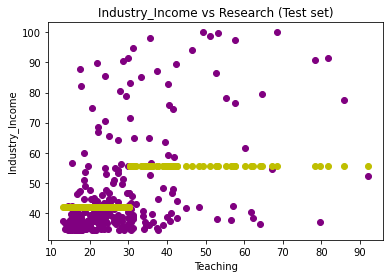

In [17]:
plt.scatter(X_test['Teaching'], y_test, color = 'purple')
plt.plot(X_test['Teaching'], dt.predict(X_test[f]), 'yo')
plt.title('Industry_Income vs Research (Test set)')
plt.xlabel('Teaching')
plt.ylabel('Industry_Income')
plt.show()

Лишь одна переменная Teaching была значима при построении дерева.

Text(0.5, 1.0, 'Tree. Feature Importance')

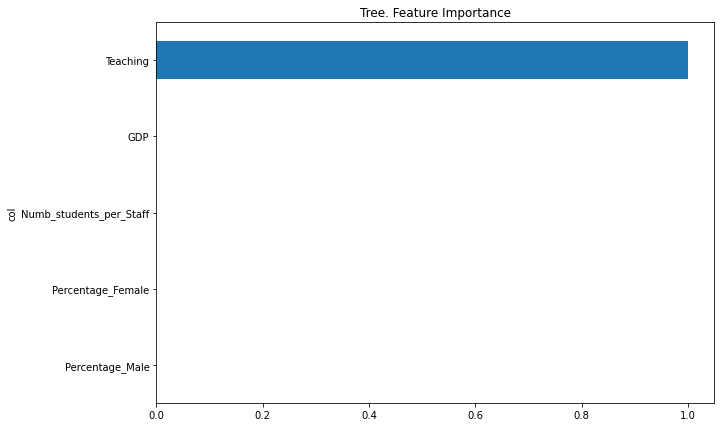

In [19]:
dt_imp = pd.DataFrame({'imp': dt.feature_importances_, 'col': X_train[f].columns})
dt_imp = dt_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-10:]
dt_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Tree. Feature Importance')

### Промежуточный вывод: низкий коэффициент детерминации (даже ниже, чем у линейной простой регрессии!), переобученная модель, значимость только преподавания...Выглядит всё грустно и скучно. Явно этот вариант дерево решений не позволит нам сделать точные выводы по поводу дохода университета и влияющих факторов.

## Random Forest

Действия ниже для определения количества деревьев.

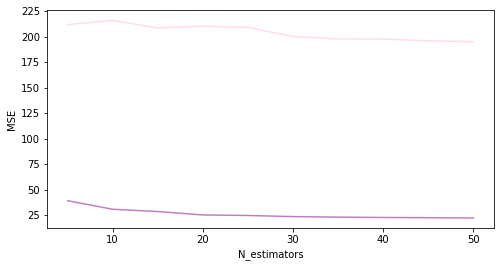

In [20]:
def rf_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, rf.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='purple', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='pink', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    

from sklearn.ensemble import RandomForestRegressor    
rf_best_n_estimator(X_train[f], X_test[f], y_train, y_test, [5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

Теперь действия для определения количества веток.

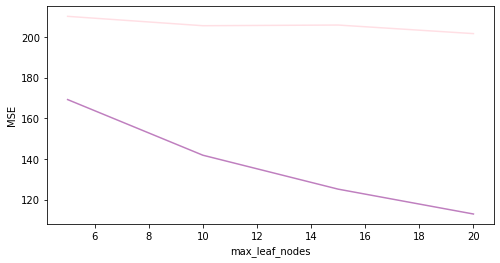

In [21]:
def rf_max_leaf_nodes(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=40, max_leaf_nodes =i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, rf.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='purple', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='pink', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_leaf_nodes")
    
rf_max_leaf_nodes(X_train[f], X_test[f], y_train, y_test, [5, 10, 15, 20])

Проделав несколько экспериментов, делаем вывод, что наиболее оптимальным вариантом явялется 30 деревьев и 4 ветви. Так модель несильно переобучена и имеет хороший коэффициент детерминации.

In [22]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 30, max_leaf_nodes = 4, random_state = 10).fit(X_train[f], y_train)

rf_y_pred = rf.predict(X_test[f])

metrics(X_train[f], X_test[f], y_train, y_test, rf_y_pred, rf).round(2)

,RMSE,R2
Train,13.29,0.32
Test,14.54,0.23


Визуализация.

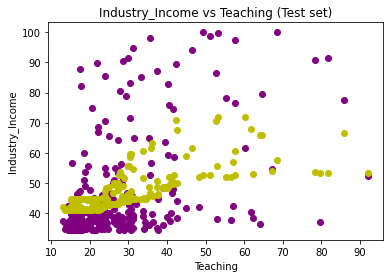

In [23]:
plt.scatter(X_test['Teaching'], y_test, color = 'purple')
plt.plot(X_test['Teaching'], rf.predict(X_test[f]), 'yo')
plt.title('Industry_Income vs Teaching (Test set)')
plt.xlabel('Teaching')
plt.ylabel('Industry_Income')
plt.show()

Теперь помимо преподавания значимыми являются и остальные факторы, особенно % женщин.

Text(0.5, 1.0, 'Random Forest. Feature Importance')

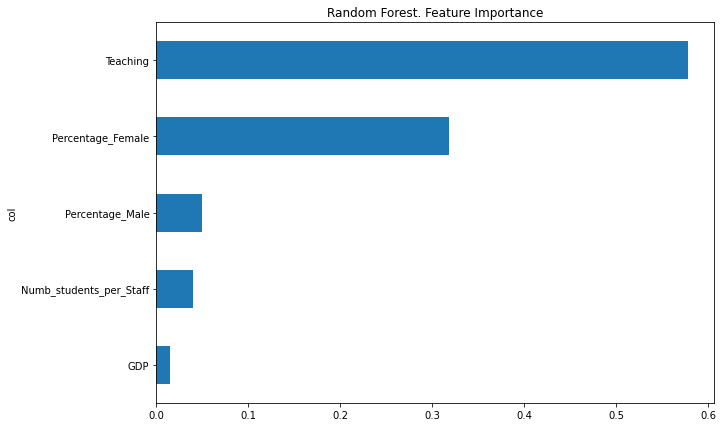

In [24]:
rf_imp = pd.DataFrame({'imp': rf.feature_importances_, 'col': X_train[f].columns})
rf_imp = rf_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
rf_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Random Forest. Feature Importance')

### Промежуточный вывод: случайный лес уже выглядит поинтереснее и поэффективнее, чем предыдущий метод (см. на R2 и ошибки). Та и значимость других переменных выросла, что даёт более широкие возможности для анализа.

## CatBoost

!pip install catboost

Выбор количества итераций.

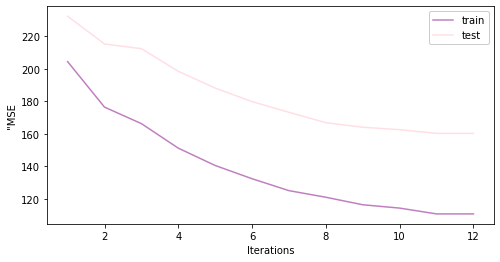

In [26]:
def catboost_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=i,random_state=10,eval_metric='RMSE',loss_function='RMSE').fit(X_train, y_train,eval_set=(X_test, y_test),logging_level='Silent')
        mse_train.append(mean_squared_error(y_train, catboost.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, catboost.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='purple', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='pink', label='test')
    ax.set_ylabel('"MSE')
    ax.set_xlabel('Iterations')
    ax.legend(framealpha=1, frameon=True);
    
from catboost import CatBoostRegressor
catboost_best_n_estimator(X_train[f], X_test[f], y_train, y_test, list(range(1,13)))

Выбор глубины.

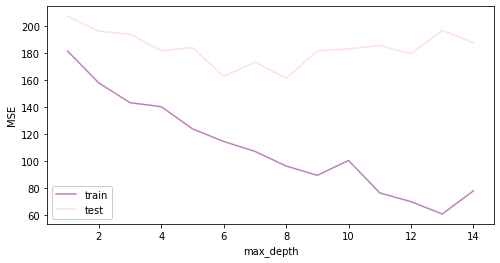

In [27]:
def catboost_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=10,max_depth=i,random_state=10,eval_metric='RMSE',loss_function='RMSE').fit(X_train,y_train,eval_set=(X_test, y_test),logging_level='Silent')
        mse_train.append(mean_squared_error(y_train, catboost.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, catboost.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='purple', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='pink', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

catboost_max_depth(X_train[f], X_test[f], y_train, y_test, list(range(1,15)))

При 12 итерациях и глубине 4 имеет наилучшие показатели.

In [28]:
cb = CatBoostRegressor(iterations=12,max_depth=4,random_state=10,eval_metric='RMSE',loss_function='RMSE').fit(X_train[f], y_train,eval_set=(X_test[f], y_test),logging_level='Silent')

cb_y_pred = cb.predict(X_test[f])

metrics(X_train[f], X_test[f], y_train, y_test, cb_y_pred, cb).round(2)

,RMSE,R2
Train,11.34,0.51
Test,13.18,0.37


Видим, что при построении этой модели все переменные значимы, а особенно ВВП, % женщин и преподавание.

Text(0.5, 1.0, 'Boosting. Feature Importance')

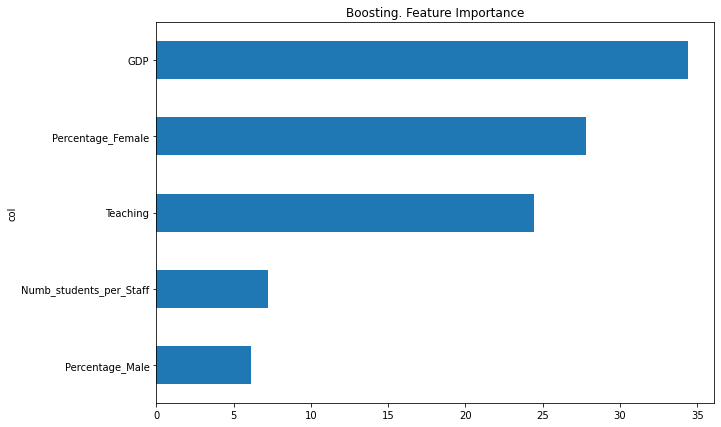

In [29]:
cb_imp = pd.DataFrame({'imp': cb.get_feature_importance(), 'col': X_train[f].columns})
cb_imp = cb_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-25:]
cb_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Boosting. Feature Importance')

Визуализация (пока наилучшая из всех предыдущих)

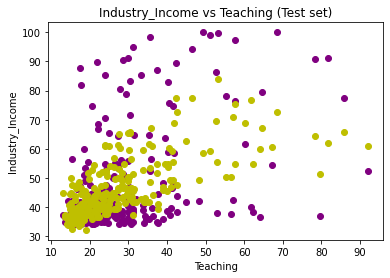

In [30]:
plt.scatter(X_test['Teaching'], y_test, color = 'purple')
plt.plot(X_test['Teaching'], cb.predict(X_test[f]), 'yo')
plt.title('Industry_Income vs Teaching (Test set)')
plt.xlabel('Teaching')
plt.ylabel('Industry_Income')
plt.show()

### Промежуточный вывод: CatBoost позволил максимально описать наши данные и свести ошибки к минимуму. Модель немного переобучена. Видим, что в данном случае на доход оказывает наибольшее влияние ВВП, % женщин и уровень преподавания.

Вывод всех метрик для сравнения. Безусловно, Catboost является самым оптимальным вариантом (сравниваем RMSE и R2)

In [31]:
metric_dt = metrics(X_train[f], X_test[f], y_train,y_test, dt_y_pred, dt).round(2).abs()
metric_dt['Type'] = 'Tree'

metric_rf = metrics(X_train[f], X_test[f], y_train,y_test,  rf_y_pred, rf).round(2).abs()
metric_rf['Type'] = 'Random forest'

metric_cb = metrics(X_train[f], X_test[f], y_train,y_test, cb_y_pred, cb).round(2)
metric_cb['Type'] = 'Catboost'

metric = pd.concat([metric_dt,metric_rf,metric_cb])
metric

,RMSE,R2,Type
Train,14.87,0.15,Tree
Test,15.29,0.15,Tree
Train,13.29,0.32,Random forest
Test,14.54,0.23,Random forest
Train,11.34,0.51,Catboost
Test,13.18,0.37,Catboost
